In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF
import numpy.random as rand
from sklearn.metrics import roc_curve,auc
import numpy.linalg as la

from ml_enc import sNMF_L1
n_comp = 5

rand.seed(123)

### Load the data

In [2]:
X = np.genfromtxt('X_mod_fashion.csv',delimiter=',')
Y = np.genfromtxt('Y_fashion.txt')

### Determine the classes we wish to compare

In [3]:
class_1 = 0
class_2 = 6
indxs = (class_1==Y)|(class_2==Y)

X = X[indxs]
Y = Y[indxs]
Y[class_1==Y] = 0
Y[class_2==Y] = 1

In [4]:
idx_train = rand.binomial(1,size=X.shape[0],p=.7)
X_train = X[idx_train==1]
Y_train = Y[idx_train==1]
X_test = X[idx_train==0]
Y_test = Y[idx_train==0]

## Make sure we have a good initialization

In [5]:
modNMF = NMF(n_comp)
modNMF.fit(X_train)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [6]:
S_init = modNMF.transform(X_train).astype(np.float32)
W_init = modNMF.components_.astype(np.float32)

## Actually fit the model

In [7]:
model = sNMF_L1(5,nIter=50000,LR=5e-4,mu=10.0,reg=1.0)

In [8]:
S = model.fit_transform(X_train,Y_train,W_init)

100%|██████████| 50000/50000 [06:22<00:00, 130.65it/s]


### Project the data

In [9]:
S_test_p = model.transform_noY(X_test)
S_train_p = model.transform_noY(X_train)

## Look at the training

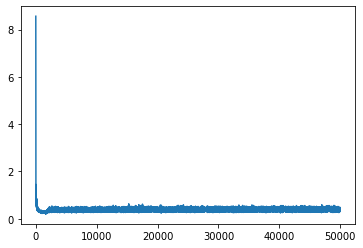

In [10]:
plt.plot(model.losses_gen)

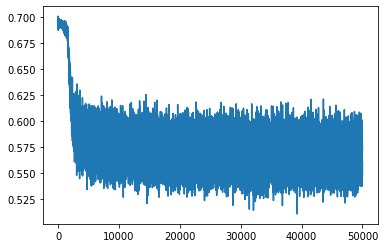

In [11]:
plt.plot(model.losses_sup)

## Lets look at the reconstruction

In [12]:
X_recon = np.dot(S,model.components_)
X_recon2_p = np.dot(S_train_p,model.components_)

In [13]:
print('Random guessing ',np.mean(X_train**2))
print('Joint training ',np.mean((X_train-X_recon)**2))
print('Projecting ',np.mean((X_train-X_recon2_p)**2))

Random guessing  0.22234220178615338
Joint training  0.10592457075239667
Projecting  0.10592457312002304


In [14]:
phi = model.phi_
b = model.b_

## Look at the predictions

In [15]:
logits_train_p = np.dot(S_train_p,phi) + b
logits_test_p = np.dot(S_test_p,phi) + b

In [16]:
fpr,tpr,_ = roc_curve(Y_train,logits_train_p)
print(auc(fpr,tpr))
fpr,tpr,_ = roc_curve(Y_test,logits_test_p)
print(auc(fpr,tpr))

0.9064167455590426
0.8875230416335312


In [17]:
import pickle

In [18]:
myDict = {'Object':model}
pickle.dump(myDict,open('MNIST_Fashion_06.p','wb'))